# IceCube - EDA

## Load Data

In [1]:
%cd ..

/home/jovyan/working


In [2]:
import sys

sys.path.append(".")

In [3]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [119]:
import glob
import math
import os
import re

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import euclidean, pdist

# from pandas_profiling import ProfileReport

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [86]:
from src.ice_cube.data_loader import make_test_dataloader
from src.ice_cube.model import load_pretrained_model
from src.ice_cube.scoring import angular_dist_score
from src.load_data import LoadData
from src.preprocesses.cache import fit_instance, transform_data
from src.preprocesses.p001_dist_transformer import DistTransformer
from src.ice_cube.submission import to_submission_df
from src.ice_cube.sqlite import world_dist
from src.utils import choice_seed, df_stats, fix_seed

In [6]:
# Competition specific packages
import os
import sqlite3
from typing import Any, Dict, List, Optional

import pyarrow.parquet as pq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from graphnet.data.constants import FEATURES, TRUTH
from graphnet.data.sqlite import SQLiteDataset

# import sqlalchemy
# import graphnet
# from graphnet.data.sqlite.sqlite_utilities import create_table

In [7]:
c_main = OmegaConf.load("./config/main.yaml")
c_data = OmegaConf.load("./config/data.yaml")
c = OmegaConf.merge(c_main, c_data)

fix_seed(choice_seed(c))

2023-03-07 11:07:25,158 [INFO] [utils] Fix seed: 440


In [8]:
input = LoadData(c, use_fold=False, do_preprocess=False)

2023-03-07 11:07:38,732 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/train_meta.parquet
2023-03-07 11:07:48,117 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/test_meta.parquet
2023-03-07 11:07:48,124 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
2023-03-07 11:07:48,128 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv


In [11]:
[col for col in dir(input) if not col.startswith("__")]

['c', 'sample_submission', 'sensor_geometry', 'test_meta', 'train_meta']

In [9]:
results = pd.read_csv("results.csv")
submission_low_sigma = pd.read_csv("submission_low_sigma.csv")
submission_high_sigma = pd.read_csv("submission_high_sigma.csv")
submission_df = pd.read_csv("submission.csv")
valid_df = pd.read_csv("valid.csv")

In [10]:
results2 = pd.read_csv("results2.csv")
submission_low_sigma2 = pd.read_csv("submission_low_sigma2.csv")
submission_high_sigma2 = pd.read_csv("submission_high_sigma2.csv")
submission2_df = pd.read_csv("submission2.csv")
valid2_df = pd.read_csv("valid2.csv")

## Check Data

In [11]:
input.sample_submission.shape

(3, 3)

In [12]:
input.sample_submission

,event_id,azimuth,zenith
0,2092,1,1
1,7344,1,1
2,9482,1,1


In [13]:
input.sensor_geometry.shape

(5160, 4)

In [14]:
input.sensor_geometry

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


In [15]:
input.sensor_geometry.describe()

,sensor_id,x,y,z
count,5160.000000,5160.000000,5160.000000,5160.000000
mean,2579.500000,5.870829,-2.518609,-23.905766
std,1489.708025,285.151213,269.409729,296.456563
min,0.000000,-570.900000,-521.080000,-512.820000
25%,1289.750000,-224.090000,-209.070000,-283.200000
50%,2579.500000,16.990000,-6.055000,-35.115000
75%,3869.250000,224.580000,211.660000,228.557500
max,5159.000000,576.370000,509.500000,524.560000


In [16]:
input.test_meta.shape

(3, 4)

In [17]:
input.test_meta

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [18]:
input.train_meta.shape

(131953924, 6)

In [19]:
input.train_meta

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
...,...,...,...,...,...,...
131953919,660,2147483597,24339210,24339349,5.895612,0.333071
131953920,660,2147483603,24339350,24339383,3.273695,1.503301
131953921,660,2147483617,24339384,24339424,2.945376,1.723253
131953922,660,2147483626,24339425,24339499,1.616582,1.937025


In [20]:
input.train_meta[input.train_meta["batch_id"] == 440]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
87800000,440,1428988469,0,68,0.043206,1.044615
87800001,440,1428988485,69,127,4.788015,1.519801
87800002,440,1428988489,128,168,6.002178,1.839276
87800003,440,1428988503,169,272,1.292094,1.340804
87800004,440,1428988518,273,2249,1.894584,2.006880
...,...,...,...,...,...,...
87999995,440,1432234735,33121697,33121749,3.702434,2.157144
87999996,440,1432234738,33121750,33121793,4.382589,1.891504
87999997,440,1432234762,33121794,33121934,3.655561,2.414422
87999998,440,1432234772,33121935,33121990,2.190492,2.276862


In [21]:
submission_high_sigma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148544 entries, 0 to 148543
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   event_id  148544 non-null  float64
 1   azimuth   148544 non-null  float64
 2   zenith    148544 non-null  float64
dtypes: float64(3)
memory usage: 3.4 MB


In [22]:
submission_high_sigma.head()

,event_id,azimuth,zenith
0,1.432235e+09,1.643871,1.595458
1,1.432235e+09,0.777158,1.973433
2,1.432235e+09,4.068247,0.610144
3,1.432235e+09,3.589098,1.522334
4,1.432235e+09,3.469211,2.925182


In [23]:
submission_high_sigma["event_id"] = submission_high_sigma["event_id"].astype(int)

In [25]:
submission_high_sigma.columns = ["event_id", "azimuth_preds", "zenith_preds"]

In [30]:
meta_high_sigma = pd.merge(
    input.train_meta[input.train_meta["batch_id"] == 441],
    submission_high_sigma,
    on="event_id",
)

In [31]:
meta_high_sigma.shape

(148544, 8)

In [32]:
meta_high_sigma.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,azimuth_preds,zenith_preds
0,441,1432234834,0,51,1.927610,2.137743,1.643871,1.595458
1,441,1432234838,52,109,0.605587,0.864771,0.777158,1.973433
2,441,1432234846,110,171,6.110872,1.286081,4.068247,0.610144
3,441,1432234917,346,411,2.362682,2.656823,3.589098,1.522334
4,441,1432234937,505,554,3.397901,2.148571,3.469211,2.925182


In [39]:
event_ids_high_sigma = meta_high_sigma["event_id"].to_numpy()

In [229]:
event_ids_high_sigma

array([1432234834, 1432234838, 1432234846, ..., 1435497101, 1435497111,
       1435497125], dtype=object)

In [131]:
meta_high_sigma[meta_high_sigma["event_id"] == 1432240503]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,azimuth_preds,zenith_preds
269,441,1432240503,61906,62023,2.127084,0.713541,4.142732,1.233107


In [133]:
angular_dist_score(2.127084, 0.713541, 4.142732, 1.233107)

1.5860584923139365

## Read single batch

In [20]:
batch_num = 661
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_test, f"batch_{batch_num}.parquet")
).reset_index()

In [21]:
batch.shape

(378, 5)

In [22]:
batch.loc[0:298, :]

,event_id,sensor_id,time,charge,auxiliary
0,2092,4066,6170,1.275,True
1,2092,3512,6374,0.975,True
2,2092,897,6378,1.475,True
3,2092,2060,6590,0.925,True
4,2092,3072,6625,1.075,True
...,...,...,...,...,...
294,2092,4998,22868,1.125,True
295,2092,2152,24147,0.925,True
296,2092,3229,24502,0.525,True
297,2092,5156,25399,0.875,True


In [23]:
batch["charge"].describe(percentiles=[0.1, 0.9])

count    378.000000
mean       0.989947
std        0.465175
min        0.125000
10%        0.475000
50%        0.975000
90%        1.475000
max        4.775000
Name: charge, dtype: float64

In [61]:
batch_num = 441
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_train, f"batch_{batch_num}.parquet")
).reset_index()

In [62]:
batch.shape

(32996025, 5)

In [63]:
batch

,event_id,sensor_id,time,charge,auxiliary
0,1432234834,1420,5893,1.575,True
1,1432234834,5143,6010,1.075,True
2,1432234834,842,6332,0.975,True
3,1432234834,541,6732,0.825,True
4,1432234834,685,6855,1.175,True
...,...,...,...,...,...
32996020,1435497129,2574,15041,0.975,True
32996021,1435497129,1041,15338,1.075,True
32996022,1435497129,620,15575,0.575,True
32996023,1435497129,620,15587,1.075,True


In [64]:
batch["event_id"].unique().shape

(200000,)

In [65]:
max(batch["charge"])

2902.925048828125

In [66]:
batch["charge"].describe(percentiles=[0.05, 0.9])

count    3.299602e+07
mean     3.998304e+00
std      1.608011e+01
min      2.500000e-02
5%       3.750000e-01
50%      1.075000e+00
90%      5.675000e+00
max      2.902925e+03
Name: charge, dtype: float64

In [67]:
batch = pd.merge(batch, input.sensor_geometry, on="sensor_id")

In [68]:
batch

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,1432234834,1420,5893,1.575,True,-245.65,-190.49,-178.97
1,1432235925,1420,10697,0.975,False,-245.65,-190.49,-178.97
2,1432235925,1420,10714,0.325,False,-245.65,-190.49,-178.97
3,1432240503,1420,10995,0.525,False,-245.65,-190.49,-178.97
4,1432240503,1420,11980,0.925,False,-245.65,-190.49,-178.97
...,...,...,...,...,...,...,...,...
32996020,1435489061,1957,12546,0.675,False,-324.39,-93.43,-129.63
32996021,1435490661,1957,8859,0.775,True,-324.39,-93.43,-129.63
32996022,1435491737,1957,10671,1.375,False,-324.39,-93.43,-129.63
32996023,1435491737,1957,10712,1.125,False,-324.39,-93.43,-129.63


In [41]:
batch_high_sigma = batch[batch["event_id"].isin(event_ids_high_sigma)]

In [42]:
batch_high_sigma.shape

(11677588, 5)

In [43]:
batch_high_sigma = pd.merge(batch_high_sigma, input.sensor_geometry, on="sensor_id")

In [44]:
batch_high_sigma.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,1432234834,1420,5893,1.575,True,-245.65,-190.49,-178.97
1,1432240503,1420,10995,0.525,False,-245.65,-190.49,-178.97
2,1432240503,1420,11980,0.925,False,-245.65,-190.49,-178.97
3,1432244447,1420,11636,1.625,False,-245.65,-190.49,-178.97
4,1432246299,1420,21451,1.175,True,-245.65,-190.49,-178.97


## Single Event

In [69]:
event_id = 1433407953

In [87]:
azimuth_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "azimuth"
].to_numpy()
zenith_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "zenith"
].to_numpy()
azimuth_event, zenith_event

(array([5.07349699]), array([1.61166745]))

In [88]:
line_x = math.cos(azimuth_event) * math.sin(zenith_event)
line_x_details = (-line_x * 500, line_x * 500)
line_y = math.sin(azimuth_event) * math.sin(zenith_event)
line_y_details = (-line_y * 500, line_y * 500)
line_z = math.cos(zenith_event)
line_z_details = (-line_z * 500, line_z * 500)
line_color, line_style, line_width = "r", "-", 2

In [89]:
batch_event = batch[(batch["event_id"] == event_id)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["auxiliary"] == False)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["charge"] < 1)]
batch_event.shape

(50, 8)

In [90]:
batch_event.describe()

,event_id,sensor_id,time,charge,x,y,z
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.433408e+09,2263.240000,11037.260000,0.970000,31.004400,-60.292400,-2.158000
std,0.000000e+00,1844.890225,2557.220787,0.309748,298.561217,357.033339,281.949922
min,1.433408e+09,58.000000,6168.000000,0.275000,-492.430000,-521.080000,-491.170000
25%,1.433408e+09,315.500000,9718.500000,0.725000,-211.350000,-422.830000,-259.790000
50%,1.433408e+09,2208.500000,10285.500000,0.950000,16.990000,-79.500000,102.955000
75%,1.433408e+09,4005.000000,13000.250000,1.125000,361.000000,301.010000,235.980000
max,1.433408e+09,5071.000000,16501.000000,2.025000,500.430000,509.500000,502.270000


In [91]:
batch_event.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
1215972,1433407953,3880,15931,1.275,True,174.47,315.54,-168.09
1586594,1433407953,3713,6196,0.925,True,-189.98,257.42,-400.75
1586595,1433407953,3713,13721,0.975,True,-189.98,257.42,-400.75
1601694,1433407953,4614,11355,0.925,True,-101.06,490.22,-417.64
2005871,1433407953,1440,14522,0.675,True,-121.77,-171.03,502.27


In [92]:
batch_event["auxiliary"].value_counts()

True     37
False    13
Name: auxiliary, dtype: int64

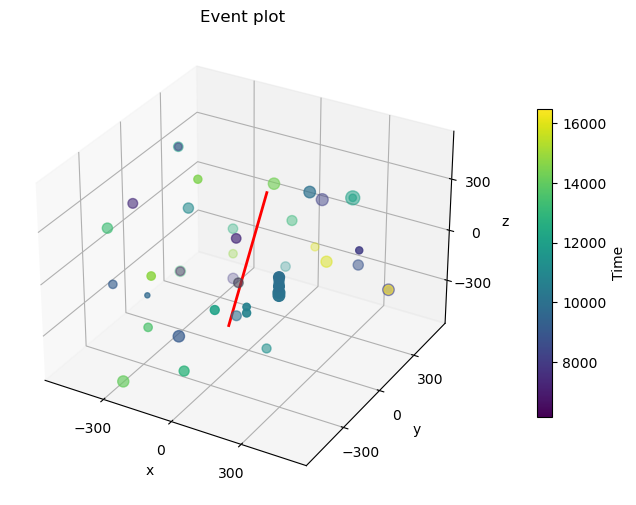

In [93]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event["x"],
    batch_event["y"],
    batch_event["z"],
    s=batch_event["charge"] * 50,
    c=batch_event["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

### 階層的クラスタリング

In [131]:
time_dist = pdist(batch_event[["time"]])

In [132]:
time_dist.shape

(1225,)

In [129]:
time_dist.min(), time_dist.max()

(1.0, 10333.0)

In [126]:
space_dist = pdist(batch_event[["x", "y", "z"]])

In [127]:
space_dist.shape

(1225,)

In [130]:
space_dist.min(), space_dist.max()

(0.0, 1258.6443347109619)

In [142]:
world_dist = space_dist / (time_dist * 0.3 + 1e-8)

In [108]:
def world_dist(u, v):
    """
    2つのベクトルの世界距離を計算する
    各ベクトルは時刻(1次元)と空間(3次元)の値を持つこと。
    """
    assert u.shape[0] == 4
    assert v.shape[0] == 4

    # ここでは時間は ナノ秒単位
    # 光は 1ナノ秒で 約0.3m 進む
    time = 0.3 * (u[0] - v[0]) ** 2 + 1e-8
    space = euclidean(u[1:], v[1:])
    return space / time

In [143]:
# h_cluster = linkage(batch_event[["time", "x", "y", "z"]], metric=world_dist)
h_cluster = linkage(world_dist)

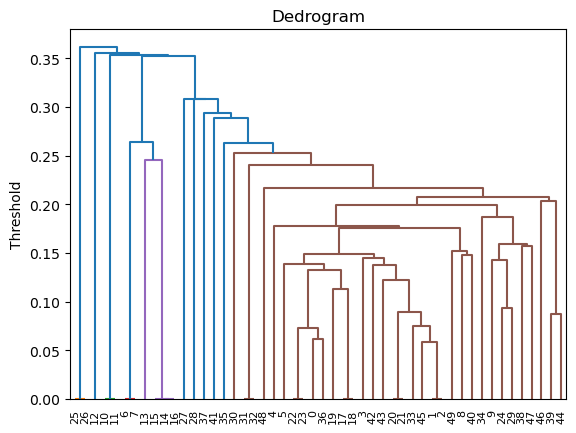

In [144]:
dendrogram(h_cluster)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

In [145]:
batch_event.loc[:, "h_labels"] = fcluster(h_cluster, 1)

In [146]:
batch_event["h_labels"].value_counts().idxmax()

5

In [147]:
batch_event["h_labels"].value_counts()

5     17
3      6
8      6
6      3
9      3
4      2
2      2
1      2
13     1
14     1
12     1
16     1
11     1
15     1
7      1
17     1
10     1
Name: h_labels, dtype: int64

In [148]:
# batch_event_ = batch_event[batch_event.duplicated(subset=["h_labels"], keep=False)]
batch_event_ = batch_event[
    batch_event["h_labels"] == batch_event["h_labels"].value_counts().idxmax()
]

In [149]:
batch_event_.shape

(17, 9)

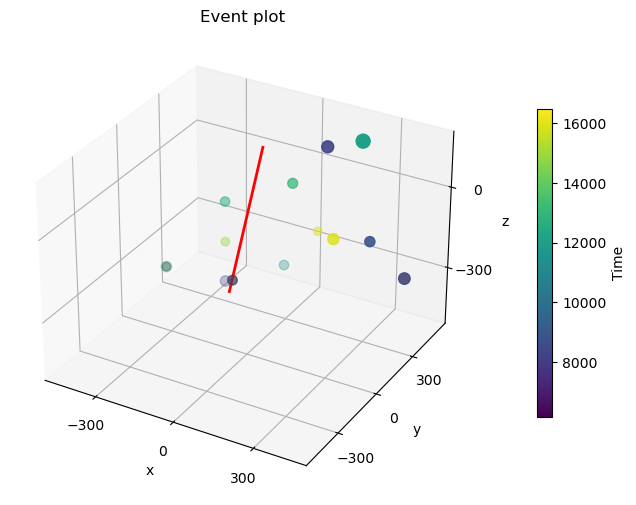

In [150]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event_["x"],
    batch_event_["y"],
    batch_event_["z"],
    s=batch_event_["charge"] * 50,
    c=batch_event_["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

## Stage 2


In [19]:
results.shape, results2.shape

((200000, 9), (148532, 9))

In [17]:
valid_df.shape, valid2_df.shape

((200000, 3), (148532, 3))

In [13]:
submission_df.shape, submission2_df.shape

((200000, 3), (148532, 3))

In [16]:
submission_high_sigma.shape, submission_low_sigma.shape, submission_high_sigma2.shape, submission_low_sigma2.shape

((148532, 3), (51468, 3), (132672, 3), (15860, 3))

In [20]:
results.columns, valid_df.columns, submission_df.columns

(Index(['Unnamed: 0', 'direction_x', 'direction_y', 'direction_z',
        'direction_kappa', 'event_id', 'zenith', 'azimuth', 'sigma'],
       dtype='object'),
 Index(['event_id', 'azimuth', 'zenith'], dtype='object'),
 Index(['event_id', 'azimuth', 'zenith'], dtype='object'))

In [24]:
def angular_dist_df(az_true, zen_true, az_pred, zen_pred):
    if not (
        np.all(np.isfinite(az_true))
        and np.all(np.isfinite(zen_true))
        and np.all(np.isfinite(az_pred))
        and np.all(np.isfinite(zen_pred))
    ):
        raise ValueError("All arguments must be finite")

    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)

    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)

    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1 * sz2 * (ca1 * ca2 + sa1 * sa2) + (cz1 * cz2)

    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod = np.clip(scalar_prod, -1, 1)

    # convert back to an angle (in radian)
    return np.abs(np.arccos(scalar_prod))

In [25]:
score = angular_dist_df(valid_df["azimuth"], valid_df["zenith"], submission_df["azimuth"], submission_df["zenith"])

In [29]:
score2 = angular_dist_df(valid2_df["azimuth"], valid2_df["zenith"], submission2_df["azimuth"], submission2_df["zenith"])

In [30]:
score.shape, score2.shape

((200000,), (148532,))

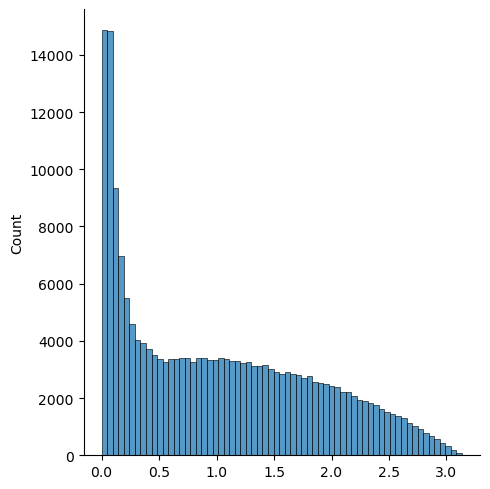

In [28]:
sns.displot(score)

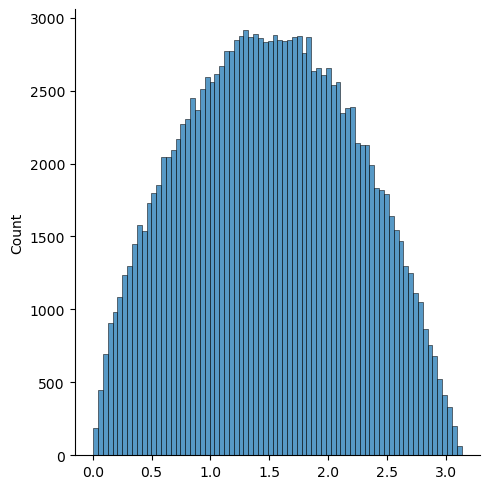

In [31]:
sns.displot(score2)

In [37]:
results["event_id"] = results["event_id"].astype(int)
results2["event_id"] = results2["event_id"].astype(int)

In [39]:
results.set_index("event_id", inplace=True)
results2.set_index("event_id", inplace=True)

In [40]:
results.head()

,Unnamed: 0,direction_x,direction_y,direction_z,direction_kappa,zenith,azimuth,sigma
event_id,,,,,,,,
1432234834,0,-0.081498,0.996279,-0.028029,2.894943,1.598829,1.652417,0.587733
1432234838,1,0.594740,0.694896,-0.404231,0.198128,1.986935,0.862905,2.246608
1432234846,2,-0.265491,-0.513100,0.816237,0.612691,0.615929,4.234899,1.277554
1432234854,3,-0.108525,-0.868838,0.483056,57.358788,1.066655,4.588124,0.132038
1432234879,4,-0.278888,0.924592,-0.259522,112.786026,1.833323,1.863751,0.094161


In [41]:
results2.head()

,Unnamed: 0,direction_x,direction_y,direction_z,direction_kappa,zenith,azimuth,sigma
event_id,,,,,,,,
1432234834,0,-0.748611,-0.532357,0.395192,0.838258,1.164520,3.759747,1.092223
1432234838,1,-0.100406,0.489873,-0.865991,0.084622,2.617927,1.772959,3.437632
1432234846,2,-0.049156,0.098369,0.993935,3.052524,0.110190,2.034216,0.572362
1432234917,3,-0.710638,-0.442473,0.547001,0.251964,0.992018,3.698495,1.992189
1432234937,4,-0.583771,-0.465738,0.665055,0.300217,0.843228,3.814997,1.825081


In [42]:
results_by2 = results.loc[results2.index, :]

In [43]:
results_by2.shape

(148532, 8)

In [46]:
results_merge_1_2 = (results_by2 + results2) / 2

In [47]:
results_merge_1_2.head()

,Unnamed: 0,direction_x,direction_y,direction_z,direction_kappa,zenith,azimuth,sigma
event_id,,,,,,,,
1432234834,0.0,-0.415055,0.231961,0.183581,1.866601,1.381674,2.706082,0.839978
1432234838,1.0,0.247167,0.592384,-0.635111,0.141375,2.302431,1.317932,2.842120
1432234846,2.0,-0.157323,-0.207365,0.905086,1.832607,0.363059,3.134557,0.924958
1432234917,4.0,-0.804915,-0.438662,0.297787,0.283726,1.257111,3.645265,1.886277
1432234937,6.0,-0.393131,-0.267579,-0.155882,0.275117,1.884545,3.643430,1.912508


In [51]:
submission_merge_1_2 = to_submission_df(results_merge_1_2.reset_index())

/home/jovyan/working/src/ice_cube/submission.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["azimuth" + angle_post_fix][df["azimuth" + angle_post_fix] < 0] + 2 * np.pi


In [54]:
submission_merge_1_2

,azimuth,zenith
event_id,,
1432234834,2.631966,1.202329
1432234838,1.175516,2.350893
1432234846,4.063357,0.280030
1432234917,3.640573,1.256698
1432234937,3.739204,1.887551
...,...,...
1435497073,5.003512,1.737909
1435497074,4.884818,0.768569
1435497101,3.732343,0.633420


In [57]:
valid2_df.set_index("event_id", inplace=True)

In [58]:
score_merge_1_2 = angular_dist_df(valid2_df["azimuth"], valid2_df["zenith"], submission_merge_1_2["azimuth"], submission_merge_1_2["zenith"])

In [59]:
score_merge_1_2

event_id
1.432235e+09    1.152484
1.432235e+09    1.571721
1.432235e+09    1.422022
1.432235e+09    1.716706
1.432235e+09    0.402172
                  ...   
1.435497e+09    1.843692
1.435497e+09    1.333910
1.435497e+09    2.651963
1.435497e+09    0.475223
1.435497e+09    1.914332
Length: 148532, dtype: float64

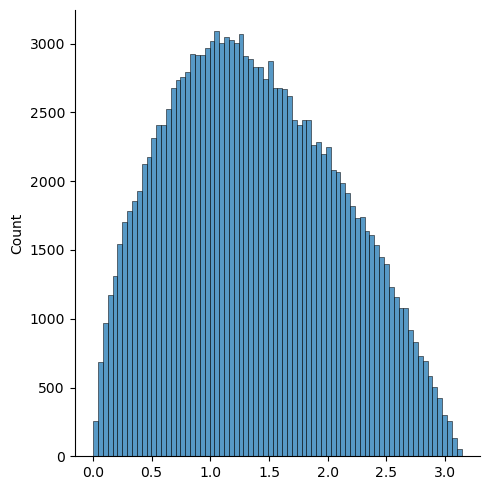

In [60]:
sns.displot(score_merge_1_2)